# Jorge Andrés Villa Vélez - s1828592

# Photometric Redshifts of Galaxies

In this excercise I will address the solutions for DBDM 2017 - Final Project excercise one "Photometric Redshifts of Galaxies"

All the solutions were addressed using python and different useful packages to properly analyze and retrive the required information. 

In each section, I describe the main important features and choices I made in order to properly achive the different goals of the project. 

In [17]:
'''Standard packages are loaded'''
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.table import vstack
from astropy.io.votable import parse
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from scipy.stats import binned_statistic
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

%matplotlib inline

In [2]:
'''Functions to read CSV files and FITS images are defined in this section'''

def Binning(x, y, xmin, xmax, ymin, ymax, N = None):
    
    Nx = np.linspace(xmin, xmax, int(N))
#     Ny = np.linspace(ymin, ymax, int(N-1)) #If y is median
    Ny = np.linspace(ymin, ymax, int(N))
    
    #[0] for Mean, [1] for Median
    bins_1 = binned_statistic(x, x, bins = Nx, range = (xmin, xmax))[0] 
    bins_2 = binned_statistic(y, y, bins = Ny, range = (ymin, ymax))[0] 
                
    return bins_1, bins_2             

In [3]:
'''This is made to correct the problem of vstack and transpose with vot files
as suggested on various websites'''

A = parse('Q2/Tables/PhotoZFileA.vot')
B = parse('Q2/Tables/PhotoZFileB.vot')

Table_1 = A.get_first_table()
A_Table = Table_1.to_table().to_pandas()

Table_2 = B.get_first_table()
B_Table = Table_2.to_table().to_pandas()

In [4]:
''' Extract some data. I also compute the magnitudes following Connolly et al. (1995a) method
in order to find the photometric redshift through linear regressions.'''

Counter = A_Table['Counter']
UG      = A_Table['u-g']
GR      = A_Table['g-r']
RI      = A_Table['r-i']
IZ      = A_Table['i-z']
Z_spec  = A_Table['z_spec']

Mag_r   = A_Table['mag_r']
Mag_g   = Mag_r + GR
Mag_u   = Mag_g + UG
Mag_i   = Mag_r - RI
Mag_z   = Mag_i - IZ

All = np.vstack((Mag_u, Mag_g, Mag_r, Mag_i, Mag_z, Z_spec)).T
Mag = np.vstack((Mag_u, Mag_g, Mag_r, Mag_i, Mag_z)).T
#Mag = np.vstack((Mag_u, Mag_g, Mag_r, Mag_i, Mag_z, Mag_u*Mag_u, Mag_g*Mag_g, Mag_r*Mag_r, Mag_i*Mag_i, Mag_z*Mag_z)).T

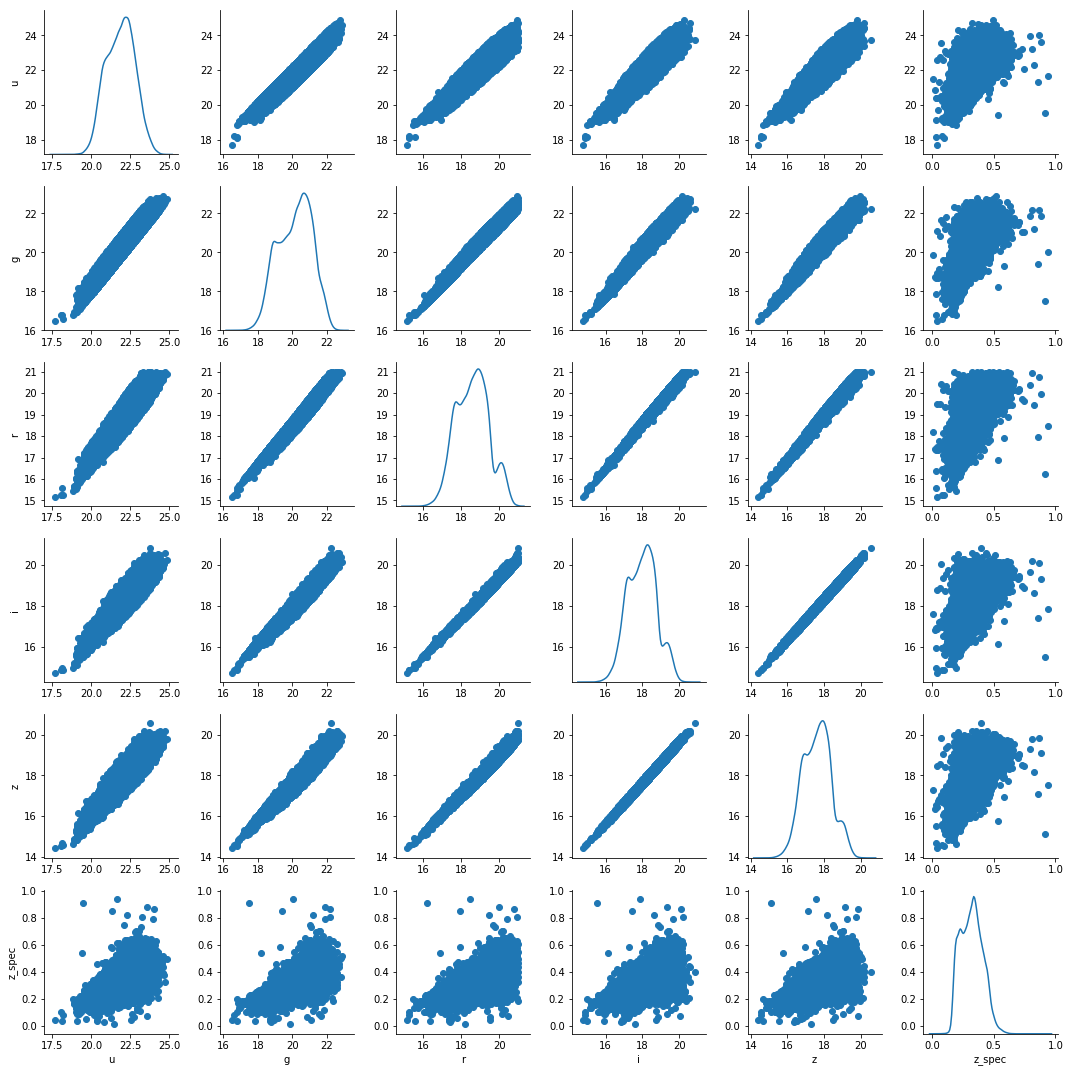

In [5]:
df = pd.DataFrame(All, columns=['u', 'g', 'r', 'i', 'z', 'z_spec'])
g = sns.PairGrid(df, diag_sharey=False)
# g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(plt.scatter)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot)

plt.savefig('DATA.png', pdi = 300)

# b) Linear regressor estimators 

In [6]:
'''Fitting - LinearRegression'''

model_1              = LinearRegression(fit_intercept = True, normalize = True)
res_1                = model_1.fit(Mag, Z_spec)
Z_phot_1             = model_1.predict(Mag)
residuals_1          = Z_phot_1 - Z_spec
relative_residuals_1 = residuals_1/Z_spec

# Note that the intercept for Ridge regression is somewhat hidden..
c_1 = [res_1.intercept_]
[c_1.append(coeff) for coeff in res_1.coef_]

print("Fitting - LinearRegression\n")
print(" The best-fit model is:\n\n   Zphot = {0:.3f} + {1:.3f} (mag_u) + {2:.3f} (mag_g) \
+ {3:.3f} (mag_r) + {4:.3f} (mag_i) + {5:.3f} (mag_z)".format(c_1[0], c_1[1], c_1[2], c_1[3], c_1[4], c_1[5]))

Discrepancy_1 = np.median( np.abs( (Z_spec - Z_phot_1)/(1.0 + Z_spec) ) )

print("\n The training error for LinearRegression is:\n\n   E = %.5f"%Discrepancy_1)
print("----------------------------------------------------------------------------------------------")

'''Fitting - Ridge'''

model_2              = Ridge(alpha = 0.0005, fit_intercept = True, normalize = True)
res_2                = model_2.fit(Mag, Z_spec)
Z_phot_2             = model_2.predict(Mag)
residuals_2          = Z_phot_2 - Z_spec
relative_residuals_2 = residuals_2/Z_spec

# Note that the intercept for Ridge regression is somewhat hidden..
c_2 = [res_2.intercept_]
[c_2.append(coeff) for coeff in res_2.coef_]

print("Fitting - Ridge\n")
print(" The best-fit model is:\n\n   Zphot = {0:.3f} + {1:.3f} (mag_u) + {2:.3f} (mag_g) \
+ {3:.3f} (mag_r) + {4:.3f} (mag_i) + {5:.3f} (mag_z)".format(c_2[0], c_2[1], c_2[2], c_2[3], c_2[4], c_2[5]))

Discrepancy_2 = np.median( np.abs( (Z_spec - Z_phot_2)/(1.0 + Z_spec) ) )

print("\n The training error for Ridge is:\n\n   E = %.5f"%Discrepancy_2)
print("----------------------------------------------------------------------------------------------")

'''Fitting - Lasso'''

model_3              = Lasso(alpha = 0.00001, fit_intercept = True, normalize = True)
res_3                = model_3.fit(Mag, Z_spec)
Z_phot_3             = model_3.predict(Mag)
residuals_3          = Z_phot_3 - Z_spec
relative_residuals_3 = residuals_3/Z_spec

# Note that the intercept for Lasso regression is somewhat hidden..
c_3 = [res_3.intercept_]
[c_3.append(coeff) for coeff in res_3.coef_]

print("Fitting - Lasso\n")
print(" The best-fit model is:\n\n   Zphot = {0:.3f} + {1:.3f} (mag_u) + {2:.3f} (mag_g) \
+ {3:.3f} (mag_r) + {4:.3f} (mag_i) + {5:.3f} (mag_z)".format(c_3[0], c_3[1], c_3[2], c_3[3], c_3[4], c_3[5]))

Discrepancy_3 = np.median( np.abs( (Z_spec - Z_phot_3)/(1.0 + Z_spec) ) )

print("\n The training error for Lasso is:\n\n   E = %.5f"%Discrepancy_3)
print("----------------------------------------------------------------------------------------------")

Fitting - LinearRegression

 The best-fit model is:

   Zphot = -0.783 + -0.013 (mag_u) + 0.096 (mag_g) + 0.372 (mag_r) + -0.395 (mag_i) + -0.021 (mag_z)

 The training error for LinearRegression is:

   E = 0.01456
----------------------------------------------------------------------------------------------
Fitting - Ridge

 The best-fit model is:

   Zphot = -0.854 + -0.012 (mag_u) + 0.101 (mag_g) + 0.296 (mag_r) + -0.278 (mag_i) + -0.062 (mag_z)

 The training error for Ridge is:

   E = 0.01481
----------------------------------------------------------------------------------------------
Fitting - Lasso

 The best-fit model is:

   Zphot = -1.200 + 0.000 (mag_u) + 0.076 (mag_g) + 0.000 (mag_r) + 0.000 (mag_i) + 0.000 (mag_z)

 The training error for Lasso is:

   E = 0.01944
----------------------------------------------------------------------------------------------


In [7]:
'''LinearRegression always gives the best result in terms of the discrepancy. However, 
Ridge seems to work pretty well, though using values close to zero may in some way 
do the same as LinearRegression. Lasso doesn't work well because one need to set the
alpha parameter to values pretty close to zero where the function may have convergence
issues.'''

'''Although Lasso seems to have the best Discrepancy compared to Ridge, Linear Regression
keeps on being the best option. Also because the last one fits all the parameters
needed to compute the photometric redshift. This error is not a reliable estimate
of the general error '''

'Although Lasso seems to have the best Discrepancy compared to Ridge, Linear Regression\nkeeps on being the best option. Also because the last one fits all the parameters\nneeded to compute the photometric redshift. This error is not a reliable estimate\nof the general error '

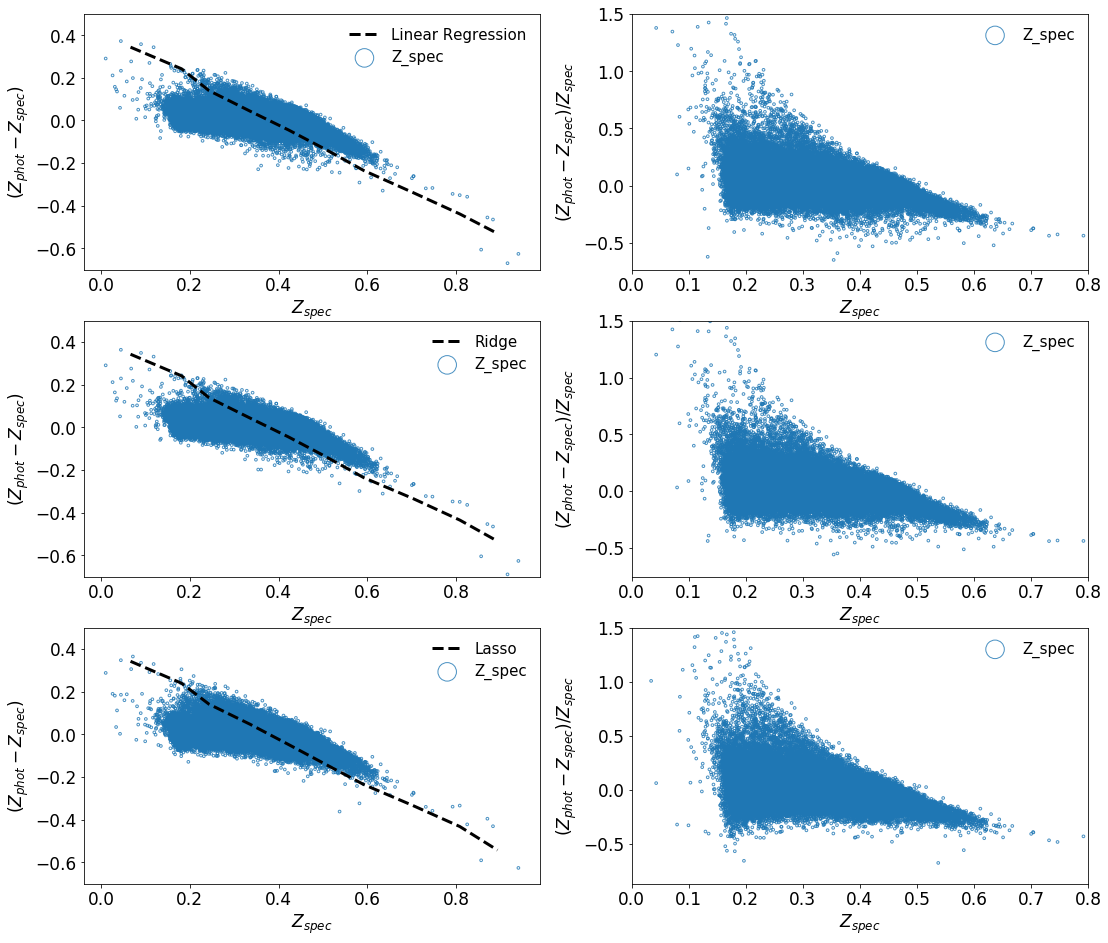

In [8]:
N = 11
X_bin_1, Y_bin_1       = Binning(Z_spec, relative_residuals_1, Z_spec.min(), Z_spec.max(), -0.6, 0.4, N)
X_bin_2, Y_bin_2       = Binning(Z_spec, relative_residuals_2, Z_spec.min(), Z_spec.max(), -0.6, 0.4, N)
X_bin_3, Y_bin_3       = Binning(Z_spec, relative_residuals_3, Z_spec.min(), Z_spec.max(), -0.6, 0.4, N)


fig, ((axA, axB), (axC, axD), (axE, axF)) = plt.subplots(figsize = (18,16), nrows = 3, ncols = 2)

axA.plot(X_bin_1, Y_bin_1[::-1], '--', lw = 3, color = 'k', label = 'Linear Regression')
axA.scatter(Z_spec, residuals_1, facecolors = 'none', edgecolors = '#1f77b4', alpha = 0.8, s = 7, label = 'Z_spec')
axA.set_xlabel(r'$Z_{spec}$', size = 17)
axA.set_ylabel(r'$(Z_{phot}-Z_{spec})$', size = 17)
axA.set_ylim(-0.7, 0.5)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 7)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)

axB.scatter(Z_spec, relative_residuals_1, facecolors = 'none', edgecolors = '#1f77b4', alpha = 0.8, s = 7, label = 'Z_spec')
axB.set_xlabel(r'$Z_{spec}$', size = 17)
axB.set_ylabel(r'$(Z_{phot}-Z_{spec})/Z_{spec}$', size = 17)
axB.set_ylim(relative_residuals_1.min(), 1.5)
axB.set_xlim(0, 0.8)
axB.legend(frameon = False, prop = {'size': 15}, markerscale = 7)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

axC.plot(X_bin_2, Y_bin_2[::-1], '--', lw = 3, color = 'k', label = 'Ridge')
axC.scatter(Z_spec, residuals_2, facecolors = 'none', edgecolors = '#1f77b4', alpha = 0.8, s = 7, label = 'Z_spec')
axC.set_xlabel(r'$Z_{spec}$', size = 17)
axC.set_ylabel(r'$(Z_{phot}-Z_{spec})$', size = 17)
axC.set_ylim(-0.7, 0.5)
axC.legend(frameon = False, prop = {'size': 15}, markerscale = 7)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

axD.scatter(Z_spec, relative_residuals_2, facecolors = 'none', edgecolors = '#1f77b4', alpha = 0.8, s = 7, label = 'Z_spec')
axD.set_xlabel(r'$Z_{spec}$', size = 17)
axD.set_ylabel(r'$(Z_{phot}-Z_{spec})/Z_{spec}$', size = 17)
axD.set_ylim(relative_residuals_2.min(), 1.5)
axD.set_xlim(0, 0.8)
axD.legend(frameon = False, prop = {'size': 15}, markerscale = 7);
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

axE.plot(X_bin_3, Y_bin_3[::-1], '--', lw = 3, color = 'k', label = 'Lasso')
axE.scatter(Z_spec, residuals_3, facecolors = 'none', edgecolors = '#1f77b4', alpha = 0.8, s = 7, label = 'Z_spec')
axE.set_xlabel(r'$Z_{spec}$', size = 17)
axE.set_ylabel(r'$(Z_{phot}-Z_{spec})$', size = 17)
axE.set_ylim(-0.7, 0.5)
axE.legend(frameon = False, prop = {'size': 15}, markerscale = 7)
axE.tick_params(axis = 'both', which = 'major', labelsize = 17)

axF.scatter(Z_spec, relative_residuals_3, facecolors = 'none', edgecolors = '#1f77b4', alpha = 0.8, s = 7, label = 'Z_spec')
axF.set_xlabel(r'$Z_{spec}$', size = 17)
axF.set_ylabel(r'$(Z_{phot}-Z_{spec})/Z_{spec}$', size = 17)
axF.set_ylim(relative_residuals_3.min(), 1.5)
axF.set_xlim(0, 0.8)
axF.legend(frameon = False, prop = {'size': 15}, markerscale = 7)
axF.tick_params(axis = 'both', which = 'major', labelsize = 17)

plt.savefig("Regression.png", dpi = 300)

# c) Using data set B to compute the generalization error

In [9]:
''' Extract some data now with data set B. I also compute the magnitudes following Connolly et al. (1995a)
method in order to find the photometric redshift through linear regressions.'''

Counter_B = B_Table['Counter']
UG_B      = B_Table['u-g']
GR_B      = B_Table['g-r']
RI_B      = B_Table['r-i']
IZ_B      = B_Table['i-z']
Z_spec_B  = B_Table['z_spec']

Mag_r_B   = B_Table['mag_r']
Mag_g_B   = Mag_r_B + GR_B
Mag_u_B   = Mag_g_B + UG_B
Mag_i_B   = Mag_r_B - RI_B
Mag_z_B   = Mag_i_B - IZ_B

All_B = np.vstack((Mag_u_B, Mag_g_B, Mag_r_B, Mag_i_B, Mag_z_B, Z_spec_B)).T
Mag_B = np.vstack((Mag_u_B, Mag_g_B, Mag_r_B, Mag_i_B, Mag_z_B)).T
#All_B = np.vstack((Mag_u, Mag_g, Mag_r, Mag_i, Mag_z,  Mag_u*Mag_u, Mag_g*Mag_g, Mag_r*Mag_r, Mag_i*Mag_i, Mag_z*Mag_z, Z_spec_B)).T
#Mag_B = np.vstack((Mag_u, Mag_g, Mag_r, Mag_i, Mag_z, Mag_u*Mag_u, Mag_g*Mag_g, Mag_r*Mag_r, Mag_i*Mag_i, Mag_z*Mag_z)).T

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

'''Fitting - LinearRegression (Same as above but weighing inverse to redshift)'''

# Mag_B    = Mag_B[:74309,:]
# Z_spec_B = Z_spec_B[:74309]

model_new              = LinearRegression(fit_intercept = True, normalize = True)
res_1_1                = model_new.fit(Mag, Z_spec, sample_weight = 1.0/(Z_spec))
Z_phot_1_1             = model_new.predict(Mag)

# Note that the intercept for Ridge regression is somewhat hidden..
c_1 = [res_1_1.intercept_]
[c_1.append(coeff) for coeff in res_1_1.coef_]

# c_1 = list(res_1.coef_)
# print(len(c_1))
print("Fitting - LinearRegression\n")
print(" The best-fit model is:\n\n   Zphot = {0:.3f} + {1:.3f} (mag_u) + {2:.3f} (mag_g) \
+ {3:.3f} (mag_r) + {4:.3f} (mag_i) + {5:.3f} (mag_z)".format(c_1[0], c_1[1], c_1[2], c_1[3], c_1[4], c_1[5]))

Discrepancy_1_1 = np.median( np.abs( (Z_spec - Z_phot_1_1)/(1.0 + Z_spec) ) )

print("\n The training error on data set A is:\n\n   E = %.5f"%Discrepancy_1_1)

Z_phot_1_2      = model_new.predict(Mag_B)
Discrepancy_1_2 = np.median( np.abs( (Z_spec_B - Z_phot_1_2)/(1.0 + Z_spec_B) ) )

print("\n The generalization error using data set B is:\n\n   E = %.5f"%Discrepancy_1_2)
print("----------------------------------------------------------------------------------------------")

Fitting - LinearRegression

 The best-fit model is:

   Zphot = -0.739 + -0.011 (mag_u) + 0.127 (mag_g) + 0.307 (mag_r) + -0.390 (mag_i) + 0.004 (mag_z)

 The training error on data set A is:

   E = 0.01433

 The generalization error using data set B is:

   E = 0.01441
----------------------------------------------------------------------------------------------


In [11]:
'''The training error is the same so I decided to PCA data in order to transform
the variables into a more suitable way to predict with our linear model. Then, 
I will PCA data set A keeping the 5 components and also data set B aiming to
obtain a training error smaller that one computed above.'''

'The training error is the same so I decided to PCA data in order to transform\nthe variables into a more suitable way to predict with our linear model. Then, \nI will PCA data set A keeping the 5 components and also data set B aiming to\nobtain a training error smaller that one computed above.'

In [12]:
'''Using PCA on A data'''

pca = PCA(whiten = True, n_components = 5)
pca.fit(Mag)

pcs     = pca.transform(Mag)
sp_depr = pca.inverse_transform(pcs)
# print(sp_depr.shape)

# plt.figure()
# plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

Mag_PCA    = sp_depr

'''Applying PCA model A on data set B'''

pca.fit(Mag_B)

pcs_B     = pca.transform(Mag_B)
sp_depr_B = pca.inverse_transform(pcs_B)

# plt.figure()
# plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

Mag_B_PCA    = sp_depr_B

In [13]:
# ALL_PCA = np.vstack((Mag_PCA[:,0:1].T, Mag_PCA[:,1:2].T, Mag_PCA[:,2:3].T, Mag_PCA[:,3:4].T, Mag_PCA[:,4:5].T, Z_spec)).T
# # Mag_B_PCA[:,:1].shape
# ALL_PCA.shape
# df = pd.DataFrame(ALL_PCA, columns=['u', 'g', 'r', 'i', 'z', 'z_spec'])
# g = sns.PairGrid(df, diag_sharey=False)
# # g.map_lower(sns.kdeplot, cmap="Blues_d")
# g.map_lower(plt.scatter)
# g.map_upper(plt.scatter)
# g.map_diag(sns.kdeplot)

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

'''Fitting - LinearRegression (Same as above but weighing inverse to redshift)'''

model_new              = LinearRegression(fit_intercept = True, normalize = True)
res_1_1                = model_new.fit(Mag_PCA, Z_spec, sample_weight = 1.0/(Z_spec))
Z_phot_1_1             = model_new.predict(Mag_PCA)

# Note that the intercept for Ridge regression is somewhat hidden..
c_1 = [res_1_1.intercept_]
[c_1.append(coeff) for coeff in res_1_1.coef_]

# c_1 = list(res_1.coef_)
# print(len(c_1))
print("Fitting - LinearRegression\n")
print(" The best-fit model is:\n\n   Zphot = {0:.3f} + {1:.3f} (mag_u) + {2:.3f} (mag_g) \
+ {3:.3f} (mag_r) + {4:.3f} (mag_i) + {5:.3f} (mag_z)".format(c_1[0], c_1[1], c_1[2], c_1[3], c_1[4], c_1[5]))

Discrepancy_1_1 = np.median( np.abs( (Z_spec - Z_phot_1_1)/(1.0 + Z_spec) ) )

print("\n The training error using data set B is:\n\n   E = %.5f"%Discrepancy_1_1)

Z_phot_1_2      = model_new.predict(Mag_B_PCA)
Discrepancy_1_2 = np.median( np.abs( (Z_spec_B - Z_phot_1_2)/(1.0 + Z_spec_B) ) )

print("\n The generalization error using data set B is:\n\n   E = %.5f"%Discrepancy_1_2)
print("----------------------------------------------------------------------------------------------")

Fitting - LinearRegression

 The best-fit model is:

   Zphot = -0.739 + -0.011 (mag_u) + 0.127 (mag_g) + 0.307 (mag_r) + -0.390 (mag_i) + 0.004 (mag_z)

 The training error using data set B is:

   E = 0.01433

 The generalization error using data set B is:

   E = 0.01441
----------------------------------------------------------------------------------------------


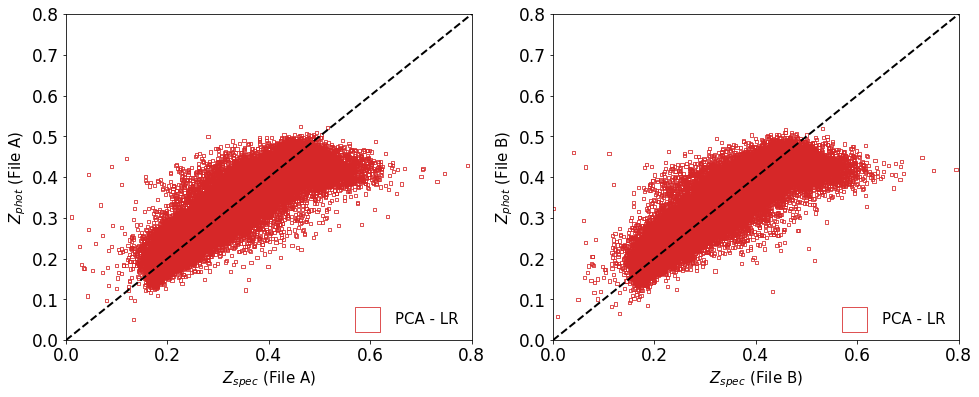

In [15]:
x = np.linspace(0, 1, 100) 

fig, ((axA, axB)) = plt.subplots(figsize = (16,6), nrows = 1, ncols = 2)

axA.scatter(Z_spec, Z_phot_1_1, facecolors = 'none', edgecolors = 'C3', marker = 's', alpha = 0.8, s = 10, label = 'PCA - LR')
axA.plot(x, x, '--', c = 'k', lw = 2)
axA.set_xlabel(r'$Z_{spec}$ (File A)', size = 15)
axA.set_ylabel(r'$Z_{phot}$ (File A)', size = 15)
axA.set_ylim(0,0.8)
axA.set_xlim(0,0.8)
axA.legend(frameon = False, loc = 'lower right', prop = {'size': 15}, markerscale = 8)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)

axB.scatter(Z_spec_B, Z_phot_1_2, facecolors = 'none', edgecolors = 'C3', marker = 's', alpha = 0.8, s = 10, label = 'PCA - LR')
axB.plot(x, x, '--', c = 'k', lw = 2)
axB.set_xlabel(r'$Z_{spec}$ (File B)', size = 15)
axB.set_ylabel(r'$Z_{phot}$ (File B)', size = 15)
axB.set_ylim(0,0.8)
axB.set_xlim(0,0.8)
axB.legend(frameon = False, loc = 'lower right', prop = {'size': 15}, markerscale = 8)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

plt.savefig("PCA.png", dpi = 300)

# d) Implementation of KNN, Bagging, Random Forest and Gaussian Processes

# Random Forest

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(Mag, Z_spec, test_size = 0.4)
# X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(Mag_B, Z_spec_B, test_size = 0.8)

# print(X_train.shape)
# print(X_test.shape)
# print(All_B[:,:10].shape)

# RandomForest = RandomForestRegressor(n_estimators = 4, criterion = 'mae', oob_score = False, n_jobs = -1)
RandomForest = RandomForestRegressor(n_estimators = 10, oob_score = False, n_jobs = -1)

# Z_phot_RF    = RandomForest.fit(X_train, y_train)
Z_phot_RF    = RandomForest.fit(Mag, Z_spec)
Pred_RF      = RandomForest.predict(Mag)
# Z_phot_RF    = RandomForest.fit(Mag, Z_spec)
#Pred = RandomForest.predict(All_B[:,:10])

# Error = Z_phot_RF.oob_score_
# print(1 - Error)
# print(Error)

Discrepancy_RF = np.median( np.abs( (Z_spec - Pred_RF)/(1.0 + Z_spec) ) )

print("\n The training error on data set A is is:\n\n   E = %.5f"%Discrepancy_RF)

Pred_RF_B = RandomForest.predict(Mag_B)
Discrepancy_RF_1 = np.median( np.abs( (Z_spec_B - Pred_RF_B)/(1.0 + Z_spec_B) ) )

print("\n The generalization error on data set B is is is:\n\n   E = %.5f"%Discrepancy_RF_1)
print("----------------------------------------------------------------------------------------------")


 The training error on data set A is is:

   E = 0.00464

 The generalization error on data set B is is is:

   E = 0.01285
----------------------------------------------------------------------------------------------


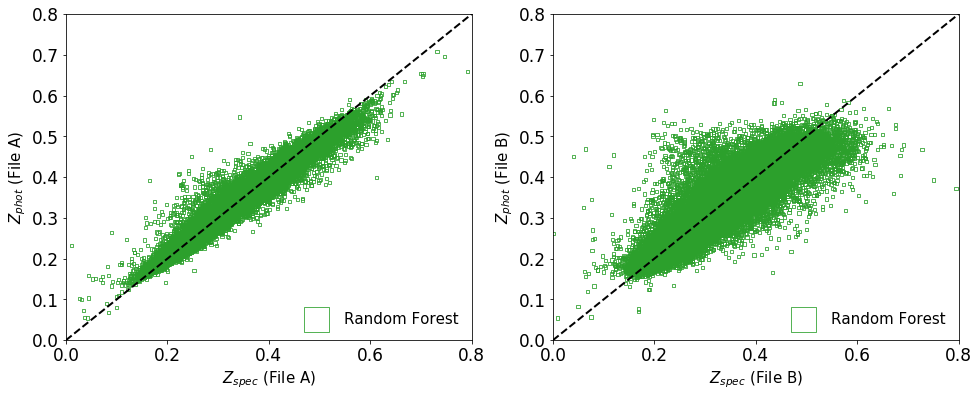

In [11]:
x = np.linspace(0, 1, 100) 

fig, ((axA, axB)) = plt.subplots(figsize = (16,6), nrows = 1, ncols = 2)

axA.scatter(Z_spec, Pred_RF, facecolors = 'none', edgecolors = 'C2', marker = 's', alpha = 0.8, s = 10, label = 'Random Forest')
axA.plot(x, x, '--', c = 'k', lw = 2)
axA.set_xlabel(r'$Z_{spec}$ (File A)', size = 15)
axA.set_ylabel(r'$Z_{phot}$ (File A)', size = 15)
axA.set_ylim(0,0.8)
axA.set_xlim(0,0.8)
axA.legend(frameon = False, loc = 'lower right', prop = {'size': 15}, markerscale = 8)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)

axB.scatter(Z_spec_B, Pred_RF_B, facecolors = 'none', edgecolors = 'C2', marker = 's', alpha = 0.8, s = 10, label = 'Random Forest')
axB.plot(x, x, '--', c = 'k', lw = 2)
axB.set_xlabel(r'$Z_{spec}$ (File B)', size = 15)
axB.set_ylabel(r'$Z_{phot}$ (File B)', size = 15)
axB.set_ylim(0,0.8)
axB.set_xlim(0,0.8)
axB.legend(frameon = False, loc = 'lower right', prop = {'size': 15}, markerscale = 8)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

plt.savefig("RandomForest.png", dpi = 300)

# Gaussian Processes

In [12]:
X_train, X_test, y_train, y_test = train_test_split(Mag, Z_spec, test_size = 0.97)

gp         = GaussianProcessRegressor(kernel = RBF(0.1), alpha = 0.0001, n_restarts_optimizer = 3, random_state = 10)
Gauss      = gp.fit(X_train, y_train)
Pred_Gauss = gp.predict(Mag)

Discrepancy_Gauss = np.median( np.abs( (Z_spec - Pred_Gauss)/(1.0 + Z_spec) ) )

print("\n The training error on data set A is is:\n\n   E = %.5f"%Discrepancy_Gauss)

Pred_Gauss_B = gp.predict(Mag_B)
Discrepancy_RF_1 = np.median( np.abs( (Z_spec_B - Pred_Gauss_B)/(1.0 + Z_spec_B) ) )

print("\n The generalization error on data set B is is is:\n\n   E = %.5f"%Discrepancy_RF_1)
print("----------------------------------------------------------------------------------------------")


 The training error on data set A is is:

   E = 0.01914

 The generalization error on data set B is is is:

   E = 0.01994
----------------------------------------------------------------------------------------------


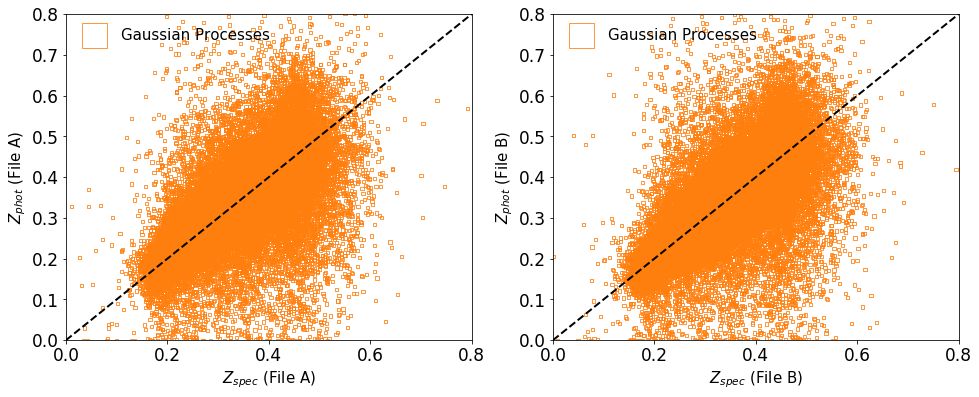

In [13]:
fig, ((axA, axB)) = plt.subplots(figsize = (16,6), nrows = 1, ncols = 2)

axA.scatter(Z_spec, Pred_Gauss, facecolors = 'none', edgecolors = 'C1', marker = 's', alpha = 0.8, s = 10, label = 'Gaussian Processes')
axA.plot(x, x, '--', c = 'k', lw = 2)
axA.set_xlabel(r'$Z_{spec}$ (File A)', size = 15)
axA.set_ylabel(r'$Z_{phot}$ (File A)', size = 15)
axA.set_ylim(0,0.8)
axA.set_xlim(0,0.8)
axA.legend(frameon = False, loc = 'upper left', prop = {'size': 15}, markerscale = 8)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)

axB.scatter(Z_spec_B, Pred_Gauss_B, facecolors = 'none', edgecolors = 'C1', marker = 's', alpha = 0.8, s = 10, label = 'Gaussian Processes')
axB.plot(x, x, '--', c = 'k', lw = 2)
axB.set_xlabel(r'$Z_{spec}$ (File B)', size = 15)
axB.set_ylabel(r'$Z_{phot}$ (File B)', size = 15)
axB.set_ylim(0,0.8)
axB.set_xlim(0,0.8)
axB.legend(frameon = False, loc = 'upper left', prop = {'size': 15}, markerscale = 8)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

plt.savefig("GaussianProcesses.png", dpi = 300)

# Bagging, ADABoost, KNN and Gradient Boosting

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(Mag, Z_spec, test_size = 0.97)

# Knn        = AdaBoostRegressor(KNeighborsRegressor(n_neighbors = 10, algorithm = 'auto', n_jobs = -1), n_estimators = 30)
# Knn        = KNeighborsRegressor(n_neighbors = 4, weights = 'uniform', algorithm = 'ball_tree', leaf_size = 5, n_jobs = -1)
# Knn        = GradientBoostingRegressor(loss = 'lad', learning_rate = 0.95, n_estimators = 300)
Knn        = BaggingRegressor(base_estimator = None, n_estimators = 20, max_samples = 0.8, max_features = 1.0, n_jobs = -1, random_state = 10)
Zphot_knn  = Knn.fit(Mag, Z_spec)
Pred_knn   = Knn.predict(Mag)

Discrepancy_KNN = np.median( np.abs( (Z_spec - Pred_knn)/(1.0 + Z_spec) ) )

print("\n The training error on data set A is is:\n\n   E = %.5f"%Discrepancy_KNN)

Zphot_knn_B = Knn.predict(Mag_B)
Discrepancy_KNN_1 = np.median( np.abs( (Z_spec_B - Zphot_knn_B)/(1.0 + Z_spec_B) ) )

print("\n The generalization error on data set B is is is:\n\n   E = %.5f"%Discrepancy_KNN_1)
print("----------------------------------------------------------------------------------------------")


 The training error on data set A is is:

   E = 0.00554

 The generalization error on data set B is is is:

   E = 0.01251
----------------------------------------------------------------------------------------------


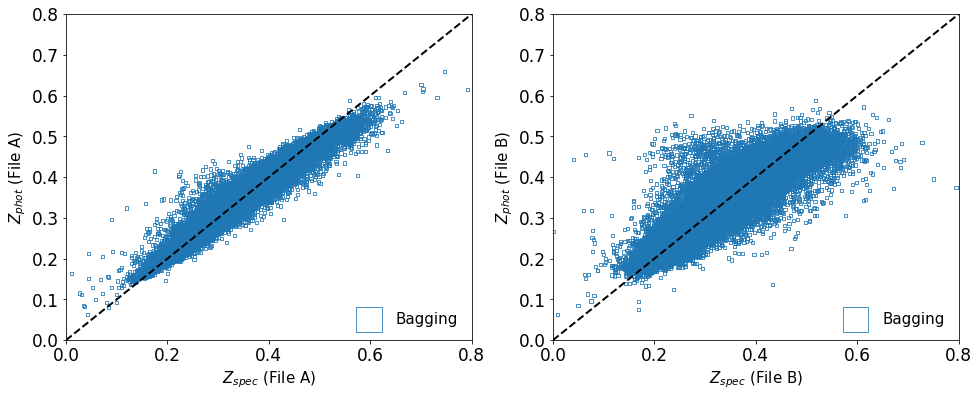

In [15]:
fig, ((axA, axB)) = plt.subplots(figsize = (16,6), nrows = 1, ncols = 2)

axA.scatter(Z_spec, Pred_knn, facecolors = 'none', edgecolors = 'C0', marker = 's', alpha = 0.8, s = 10, label = 'Bagging')
axA.plot(x, x, '--', c = 'k', lw = 2)
axA.set_xlabel(r'$Z_{spec}$ (File A)', size = 15)
axA.set_ylabel(r'$Z_{phot}$ (File A)', size = 15)
axA.set_ylim(0,0.8)
axA.set_xlim(0,0.8)
axA.legend(frameon = False, loc = 'lower right', prop = {'size': 15}, markerscale = 8)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)

axB.scatter(Z_spec_B, Zphot_knn_B, facecolors = 'none', edgecolors = 'C0', marker = 's', alpha = 0.8, s = 10, label = 'Bagging')
axB.plot(x, x, '--', c = 'k', lw = 2)
axB.set_xlabel(r'$Z_{spec}$ (File B)', size = 15)
axB.set_ylabel(r'$Z_{phot}$ (File B)', size = 15)
axB.set_ylim(0,0.8)
axB.set_xlim(0,0.8)
axB.legend(frameon = False, loc = 'lower right', prop = {'size': 15}, markerscale = 8)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

plt.savefig("KNN.png", dpi = 300)

In [18]:
os.system("mv *.png Figures/")

0

In [20]:
# from sklearn.linear_model import LinearRegression, Ridge, Lasso

# X_train, X_test, y_train, y_test = train_test_split(Mag_B, Z_spec, test_size = 0.3)
# # print(X_train.shape, y_train.shape)
# # print(X_test.shape, y_test.shape)

# lR          = LinearRegression(fit_intercept = True, normalize = True)
# Ridge       = Ridge(alpha = 0.05, fit_intercept = True, normalize = True)
# Lasso       = Lasso(alpha = 0.00001, fit_intercept = True, normalize = True)

# model_1       = lR.fit(X_train, y_train)
# predictions_1 = lR.predict(X_test)

# model_2       = Ridge.fit(X_train, y_train)
# predictions_2 = Ridge.predict(X_test)

# model_3       = Lasso.fit(X_train, y_train)
# predictions_3 = Lasso.predict(X_test)

# # predictions_1[0:5]
# # predictions_2[0:5]
# # predictions_3[0:5]

# ## The line / model
# fig, ((axA, axB, axC)) = plt.subplots(figsize = (16,5), nrows = 1, ncols = 3)

# axA.scatter(y_test, predictions_1, s = 2.5, alpha = 0.03, c = 'g')
# axA.set_xlabel("True Values", size = 15)
# axA.set_ylabel("Predictions", size = 15)
# axA.set_ylim(0.1, 0.5)
# axA.set_xlim(0.1, 0.6)
# axA.set_title("Linear Regression", size = 15)

# axB.scatter(y_test, predictions_2, s = 2.5, alpha = 0.03, c = 'g')
# axB.set_xlabel("True Values", size = 15)
# axB.set_ylabel("Predictions", size = 15)
# axB.set_ylim(0.1, 0.5)
# axB.set_xlim(0.1, 0.6)
# axB.set_title("Ridge", size = 15)

# axC.scatter(y_test, predictions_3, s = 2.5, alpha = 0.03, c = 'g')
# axC.set_xlabel("True Values", size = 15)
# axC.set_ylabel("Predictions", size = 15)
# axC.set_ylim(0.1, 0.5)
# axC.set_xlim(0.1, 0.6)
# axC.set_title("Lasso", size = 15)

# #This tells us how accurate is the model (R^2 =  1 - u/v)
# #where u = Residual sum of squares and v = Total sum of squares
# print("Score Linear Regression:", model_1.score(X_test, y_test))
# print("Score Ridge:", model_2.score(X_test, y_test))
# print("Score Lasso:", model_3.score(X_test, y_test))

In [21]:
# scores_1 = cross_val_score(model_1, Mag_B, Z_spec, cv = 3)
# scores_2 = cross_val_score(model_2, Mag_B, Z_spec, cv = 3)
# scores_3 = cross_val_score(model_3, Mag_B, Z_spec, cv = 3)

# predictions_1 = cross_val_predict(model_1, Mag_B, Z_spec, cv = 3)
# predictions_2 = cross_val_predict(model_2, Mag_B, Z_spec, cv = 3)
# predictions_3 = cross_val_predict(model_3, Mag_B, Z_spec, cv = 3)

# accuracy_1 = metrics.r2_score(Z_spec, predictions_1)
# accuracy_2 = metrics.r2_score(Z_spec, predictions_2)
# accuracy_3 = metrics.r2_score(Z_spec, predictions_3)

# fig, ((axA, axB, axC)) = plt.subplots(figsize = (16,5), nrows = 1, ncols = 3)

# axA.scatter(Z_spec, predictions_1, s = 1, alpha = 0.03, c = 'orange')
# axA.set_xlabel("True Values", size = 15)
# axA.set_ylabel("Predictions", size = 15)
# axA.set_ylim(0.1, 0.5)
# axA.set_xlim(0.1, 0.6)
# axA.set_title("Linear Regression", size = 15)

# axB.scatter(Z_spec, predictions_2, s = 1, alpha = 0.03, c = 'orange')
# axB.set_xlabel("True Values", size = 15)
# axB.set_ylabel("Predictions", size = 15)
# axB.set_ylim(0.1, 0.5)
# axB.set_xlim(0.1, 0.6)
# axB.set_title("Ridge", size = 15)

# axC.scatter(Z_spec, predictions_3, s = 1, alpha = 0.03, c = 'orange')
# axC.set_xlabel("True Values", size = 15)
# axC.set_ylabel("Predictions", size = 15)
# axC.set_ylim(0.1, 0.5)
# axC.set_xlim(0.1, 0.6)
# axC.set_title("Lasso", size = 15)

# #The last value here shows how good the training gets after several foldings (cv = 3)
# print("Cross-validated scores Linear Regression:", scores_1)
# print("Cross-validated scores Ridge:", scores_2)
# print("Cross-validated scores Lasso:", scores_3)

# #This tells us how accurate is the model (R^2 =  1 - u/v)
# #where u = Residual sum of squares and v = Total sum of squares
# print("\nCross-Predicted Accuracy:", accuracy_1)
# print("Cross-Predicted Accuracy:", accuracy_2)
# print("Cross-Predicted Accuracy:", accuracy_3)

In [96]:
# d) Implementation of a Z_phot estimator using Random Forest
# Lecture 6
# from sklearn.ensemble import RandomForestRegressor

In [97]:
#print(Mag_B[:,2:4].shape)
# X_train, X_test, y_train, y_test = train_test_split(Xkeep, Tkeep)
# X_train, X_test, y_train, y_test = train_test_split(Mag, Z_spec, test_size = 0.8)

# print(X_train.shape)
# print(X_test.shape)
# print(All_B[:,:10].shape)

In [98]:
# RandomForest = RandomForestRegressor(n_estimators = 3, criterion = 'mae', oob_score = False, n_jobs = -1)
# Z_phot_RF    = RandomForest.fit(X_train, y_train)
# Pred = RandomForest.predict(X_test)
# Z_phot_RF    = RandomForest.fit(Mag, Z_spec)
#Pred = RandomForest.predict(All_B[:,:10])

In [99]:
# Error = Z_phot_RF.oob_score_
# print(1 - Error)
# print(Error)

# Discrepancy_1_1 = np.median( np.abs( (Z_spec - Pred)/(1.0 + Z_spec) ) )
# #Discrepancy_1_1 = np.median( np.abs( (All_B[:,10] - Pred)/(1.0 + All_B[:,10]) ) )

# print("\n GE is:\n\n   E = %g"%Discrepancy_1_1)
# print("\n E is:\n\n   E = %g"%Discrepancy_1)
# print("----------------------------------------------------------------------------------------------")